In [ ]:
%load_ext jupyternotify

In [51]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from datetime import datetime

from sklearn import preprocessing
from sklearn import metrics
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import plot_partial_dependence
from xgboost import XGBRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Normalization
from tensorflow.keras import regularizers
import tensorflow.keras as keras
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers

# Data wrangling

In [52]:
pd.set_option('display.max_columns', None)

In [53]:
df = pd.read_csv('Wildfire.csv')
df = df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'fire_name','disc_date_final','cont_date_final','cont_clean_date','putout_time'])
df['disc_clean_date'] = pd.to_datetime(df['disc_clean_date'], format='%m/%d/%Y')
df.columns

Index(['fire_size', 'fire_size_class', 'stat_cause_descr', 'latitude',
       'longitude', 'state', 'disc_clean_date', 'discovery_month',
       'disc_date_pre', 'disc_pre_year', 'disc_pre_month', 'wstation_usaf',
       'dstation_m', 'wstation_wban', 'wstation_byear', 'wstation_eyear',
       'Vegetation', 'fire_mag', 'weather_file', 'Temp_pre_30', 'Temp_pre_15',
       'Temp_pre_7', 'Temp_cont', 'Wind_pre_30', 'Wind_pre_15', 'Wind_pre_7',
       'Wind_cont', 'Hum_pre_30', 'Hum_pre_15', 'Hum_pre_7', 'Hum_cont',
       'Prec_pre_30', 'Prec_pre_15', 'Prec_pre_7', 'Prec_cont', 'remoteness'],
      dtype='object')

In [54]:
#one hot encoding vegetation
df['Vegetation'] = df['Vegetation'].astype('category')
df['Cause'] = df['stat_cause_descr'].astype('category')

df = pd.get_dummies(df,prefix=['Vegetation'], columns = ['Vegetation'], drop_first=True)
df = pd.get_dummies(df,prefix=['Cause'], columns = ['stat_cause_descr'], drop_first=True)

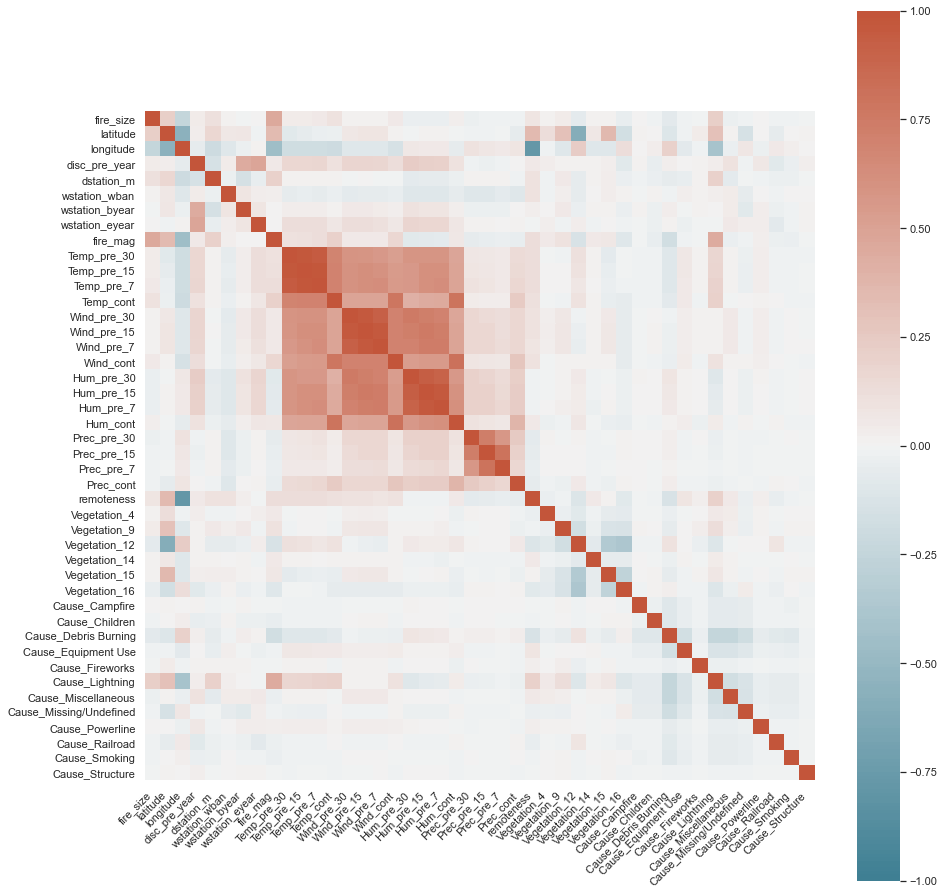

In [55]:
df_numerics_only = df.select_dtypes(include=np.number)

corr = df_numerics_only.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(220, 20, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
sns.set(rc={'figure.figsize':(15,16)})

In [56]:
#sns.pairplot(df[['latitude', 'fire_size', 'Hum_cont','Hum_pre_7', 'Hum_pre_15','Temp_pre_15', 'Temp_cont']], diag_kind='kde')

In [57]:
### Dealing with missing data
print(len(df))

# drop columns where weather file is missing
index = df[df['weather_file'] == 'File Not Found'].index
df.drop(index, inplace = True)
print(len(df))


55367
41132


In [58]:
# Weather data has a lot of 0 and values some of which may be missing values
# Mark '0' values in weather columns as Na (to see how many there are)
subset0 = ['Temp_pre_30','Temp_pre_15','Temp_pre_7','Temp_cont','Wind_pre_30','Wind_pre_15','Wind_pre_7','Wind_cont','Hum_pre_30', 'Hum_pre_15','Hum_pre_7','Hum_cont']
df[subset0] = df[subset0].replace({0:np.nan, '0':np.nan})
print(len(df))

# Mark '-1' as missing
subset_neg1 = ['Temp_pre_30','Temp_pre_15','Temp_pre_7','Temp_cont','Wind_pre_30','Wind_pre_15','Wind_pre_7','Wind_cont','Hum_pre_30', 'Hum_pre_15','Hum_pre_7','Hum_cont','Prec_pre_30','Prec_pre_15','Prec_pre_7','Prec_cont']
df[subset_neg1] = df[subset_neg1].replace({-1:np.nan})
print(len(df))

# Drop observations where all weather columns are 0
df = df.dropna(how='all',
                    subset=['Temp_pre_30','Temp_pre_15','Temp_pre_7','Temp_cont','Wind_pre_30','Wind_pre_15','Wind_pre_7','Wind_cont',])
print(len(df))
# This leaves us with 38,689 observations to work with (originally we had 50,000)
#print(" \nCount total NaN at each column in a DataFrame : \n\n",
#      df.isnull().sum())

41132
41132
38689


In [59]:
# fill the 'pre' columns temp wind and humidity with mean values
subset_fill_mean = ['Temp_pre_30','Temp_pre_15','Temp_pre_7', 'Wind_pre_30','Wind_pre_15','Wind_pre_7', 'Hum_pre_30', 'Hum_pre_15','Hum_pre_7']
df[subset_fill_mean] = df[subset_fill_mean].fillna(df[subset_fill_mean].mean())

# Fill NAs in the date of fire containment based on mean values from previous days
for col in ['Temp','Wind','Hum']:
    df[f'{col}_cont'] = df.apply(
        lambda row: (row[f'{col}_pre_7']+row[f'{col}_pre_15']+row[f'{col}_pre_30'])/3 if np.isnan(row[f'{col}_cont']) else row[f'{col}_cont'],
        axis=1)

## Experiment data preparation

### Experiment 1
Including all the available variables in the model

In [60]:
# selecting features and target variables
X1 = df[['Vegetation_4','Vegetation_9','Vegetation_12','Vegetation_14','Vegetation_15','Vegetation_16','latitude','Temp_pre_30','Temp_pre_15','Temp_pre_7','Temp_cont','Wind_pre_30','Wind_pre_15','Wind_pre_7','Wind_cont','Hum_pre_30', 'Hum_pre_15','Hum_pre_7','Hum_cont','Prec_pre_30','Prec_pre_15','Prec_pre_7','Prec_cont','Cause_Debris Burning','Cause_Equipment Use','Cause_Fireworks','Cause_Lightning','Cause_Miscellaneous','Cause_Missing/Undefined','Cause_Powerline','Cause_Railroad','Cause_Smoking','Cause_Structure', 'longitude']]
y = df['fire_size']

#X_norm = (X-X.min())/(X.max()-X.min())
#y_norm = (y-y.min())/(y.max()-y.min())

#train test split
X1_train, X1_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42)
df1 = [X1_train, X1_test, y_train, y_test]

### Experiment 2
Include only long, lat, vegetation, cause and pre- weather data, without cont-

In [61]:
# selecting features and target variables
X2 = df[['Vegetation_4','Vegetation_9','Vegetation_12','Vegetation_14','Vegetation_15','Vegetation_16','latitude','Temp_pre_30','Temp_pre_15','Temp_pre_7','Wind_pre_30','Wind_pre_15','Wind_pre_7','Hum_pre_30', 'Hum_pre_15','Hum_pre_7','Prec_pre_30','Prec_pre_15','Prec_pre_7','Cause_Debris Burning','Cause_Equipment Use','Cause_Fireworks','Cause_Lightning','Cause_Miscellaneous','Cause_Missing/Undefined','Cause_Powerline','Cause_Railroad','Cause_Smoking','Cause_Structure', 'longitude']]
y = df['fire_size']

#X_norm = (X-X.min())/(X.max()-X.min())
#y_norm = (y-y.min())/(y.max()-y.min())

#train test split
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=42)
df2 = [X2_train, X2_test, y_train, y_test]

### Experiment 3

In [62]:
# selecting features and target variables
X3 = df[['latitude','Temp_pre_30','Temp_pre_15','Temp_pre_7','Wind_pre_30','Wind_pre_15','Wind_pre_7','Hum_pre_30', 'Hum_pre_15','Hum_pre_7','Prec_pre_30','Prec_pre_15','Prec_pre_7','longitude']]
y = df['fire_size']

#train test split
X3_train, X3_test, y_train, y_test = train_test_split(X3, y, test_size=0.2, random_state=42)
df3 = [X3_train, X3_test, y_train, y_test]

### Experiment 4
Like exp 3 but with normalization

In [30]:
# normalizing data
df_4 = df[['fire_size','latitude','Temp_pre_30','Temp_pre_15','Temp_pre_7','Wind_pre_30','Wind_pre_15','Wind_pre_7','Hum_pre_30', 'Hum_pre_15','Hum_pre_7','Prec_pre_30','Prec_pre_15','Prec_pre_7','longitude']]
names = df_4.columns
df_4 = preprocessing.normalize(df_4)
scaled_df = pd.DataFrame(df_4, columns=names)

# selecting features and target variable
X4 = scaled_df[['latitude','Temp_pre_30','Temp_pre_15','Temp_pre_7','Wind_pre_30','Wind_pre_15','Wind_pre_7','Hum_pre_30', 'Hum_pre_15','Hum_pre_7','Prec_pre_30','Prec_pre_15','Prec_pre_7','longitude']]
y = scaled_df['fire_size']

#train test split
X4_train, X4_test, y_train, y_test = train_test_split(X4, y, test_size=0.2, random_state=42)
df4 = [X3_train, X4_test, y_train, y_test]

# Modelling
### Decision Tree

In [31]:
# Deccision trees
dectr = DecisionTreeRegressor(random_state=0)
dectr.fit(df1[0], df1[2])

predictions = dectr.predict(df1[1])
print('Mean Absolute Error:', metrics.mean_absolute_error(df1[3], predictions))
print('R Squared:', metrics.r2_score(df1[3], predictions))

Mean Absolute Error: 3268.2669224463684
R Squared: -0.4225369622179067


### Gradient Boosting

In [32]:
gr_boost = GradientBoostingRegressor()
gr_boost.fit(df1[0], df1[2])

predictions = gr_boost.predict(df1[1])
print('Mean Absolute Error:', metrics.mean_absolute_error(df1[3], predictions))
print('R Squared:', metrics.r2_score(df1[3], predictions))

Mean Absolute Error: 3054.4203023012333
R Squared: 0.06271628812559615


### XGBoost

In [33]:
XGBModel = XGBRegressor(n_estimators=10)
XGBModel.fit(df1[0], df1[2], verbose=True)

# Get the mean absolute error on the validation data :
XGBpredictions = XGBModel.predict(df1[1])
MAE = metrics.mean_absolute_error(df1[3] , XGBpredictions)
print('XGBoost validation MAE = ',MAE)
print('R Squared:', metrics.r2_score(df1[3], XGBpredictions))

XGBoost validation MAE =  2937.658897492385
R Squared: 0.10415435147180219


### All

In [34]:
for model in [DecisionTreeRegressor(), GradientBoostingRegressor(), RandomForestRegressor()]:
    for idx,df in enumerate([df1, df2, df3, df4]):
        model.fit(df[0], df[2])
        print(f'{model}; Experiment {idx+1}; Mean Absolute Error:', metrics.mean_absolute_error(df[3], model.predict(df[1])))
        print(f'{model}; Experiment {idx+1}; R Squared:', metrics.r2_score(df[3], model.predict(df[1])))
        print('')

DecisionTreeRegressor(); Experiment 1; Mean Absolute Error: 3294.4454749935385
DecisionTreeRegressor(); Experiment 1; R Squared: -0.42421437754284774

DecisionTreeRegressor(); Experiment 2; Mean Absolute Error: 3150.9594348914447
DecisionTreeRegressor(); Experiment 2; R Squared: -0.24977310375025064

DecisionTreeRegressor(); Experiment 3; Mean Absolute Error: 3294.5658450129235
DecisionTreeRegressor(); Experiment 3; R Squared: -0.2767672156703276

DecisionTreeRegressor(); Experiment 4; Mean Absolute Error: 0.17908107577344007
DecisionTreeRegressor(); Experiment 4; R Squared: -0.2446986792124426

GradientBoostingRegressor(); Experiment 1; Mean Absolute Error: 3069.0064810719587
GradientBoostingRegressor(); Experiment 1; R Squared: 0.04554090177698933

GradientBoostingRegressor(); Experiment 2; Mean Absolute Error: 3041.599624718311
GradientBoostingRegressor(); Experiment 2; R Squared: 0.10429882967366144

GradientBoostingRegressor(); Experiment 3; Mean Absolute Error: 3095.5054475403617

### Hyper-parameter tuning
Performing Grid Search
Testing the model with different values for parameters like the number of estimators and maximum depth, and then selects the parametres that produce the best results.

The basemodel of Random Forest Regressor produced the best results, so that is the algorithm we will tune.

In [38]:
rf_reg = RandomForestRegressor()
search_grid={'n_estimators':[50,100,200,400],'max_depth':[2,4,8,10,14]}
search=GridSearchCV(estimator=rf_reg,param_grid=search_grid,scoring='neg_mean_absolute_error',n_jobs=1,cv=5, verbose=10)
search.fit(df1[0], df1[2])
print(search.best_score_)
print(search.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5; 1/20] START max_depth=2, n_estimators=50...............................
[CV 1/5; 1/20] END .............max_depth=2, n_estimators=50; total time=   2.4s
[CV 2/5; 1/20] START max_depth=2, n_estimators=50...............................
[CV 2/5; 1/20] END .............max_depth=2, n_estimators=50; total time=   2.4s
[CV 3/5; 1/20] START max_depth=2, n_estimators=50...............................
[CV 3/5; 1/20] END .............max_depth=2, n_estimators=50; total time=   2.4s
[CV 4/5; 1/20] START max_depth=2, n_estimators=50...............................
[CV 4/5; 1/20] END .............max_depth=2, n_estimators=50; total time=   2.4s
[CV 5/5; 1/20] START max_depth=2, n_estimators=50...............................
[CV 5/5; 1/20] END .............max_depth=2, n_estimators=50; total time=   2.4s
[CV 1/5; 2/20] START max_depth=2, n_estimators=100..............................
[CV 1/5; 2/20] END ............max_depth=2, n_e

[CV 1/5; 11/20] END ...........max_depth=8, n_estimators=200; total time=  36.1s
[CV 2/5; 11/20] START max_depth=8, n_estimators=200.............................
[CV 2/5; 11/20] END ...........max_depth=8, n_estimators=200; total time=  36.9s
[CV 3/5; 11/20] START max_depth=8, n_estimators=200.............................
[CV 3/5; 11/20] END ...........max_depth=8, n_estimators=200; total time=  39.9s
[CV 4/5; 11/20] START max_depth=8, n_estimators=200.............................
[CV 4/5; 11/20] END ...........max_depth=8, n_estimators=200; total time=  36.7s
[CV 5/5; 11/20] START max_depth=8, n_estimators=200.............................
[CV 5/5; 11/20] END ...........max_depth=8, n_estimators=200; total time=  36.8s
[CV 1/5; 12/20] START max_depth=8, n_estimators=400.............................
[CV 1/5; 12/20] END ...........max_depth=8, n_estimators=400; total time= 1.3min
[CV 2/5; 12/20] START max_depth=8, n_estimators=400.............................
[CV 2/5; 12/20] END ........

### Random Forest
Running Random Forest with parameters found with GridSearch

In [43]:
# Random Forest Regressor 
rf_reg = RandomForestRegressor(n_estimators = 50, max_depth=10)

# fit the regressor with x and y data
rf_reg.fit(df1[0], df1[2])

RandomForestRegressor(max_depth=10, n_estimators=50)

In [44]:
predictions = rf_reg.predict(df1[1])
print('Mean Absolute Error:', metrics.mean_absolute_error(df1[3], predictions))
print('R Squared:', metrics.r2_score(df1[3], predictions))

Mean Absolute Error: 2974.302639507837
R Squared: 0.1168711760029264


### Fetaure Importance
What features are the most influential in the model?

In [47]:
feature_importances = pd.DataFrame(rf_reg.feature_importances_,
    index = df1[0].columns,columns=['importance']).sort_values('importance',ascending=False)
feature_importances

,importance
latitude,0.200648
Hum_cont,0.114913
longitude,0.098482
Temp_cont,0.067834
Wind_pre_7,0.062994
Wind_cont,0.051391
Hum_pre_30,0.050807
Temp_pre_30,0.045428
Hum_pre_7,0.044763
Wind_pre_15,0.041660


### Partial Dependence Plot
See how each feature affects  the target variable

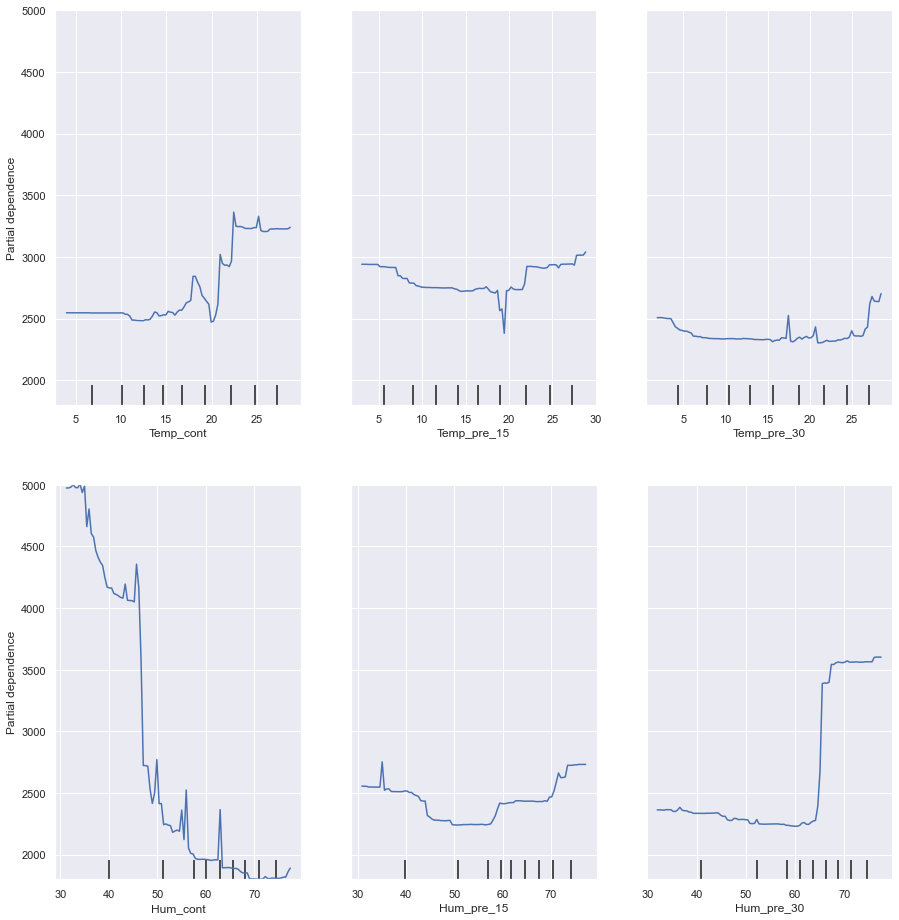

In [49]:
features = ['Temp_cont','Temp_pre_15', 'Temp_pre_30','Hum_cont','Hum_pre_15','Hum_pre_30']
plot_partial_dependence(rf_reg, df1[0], features)

Reevaluate model after deleting least important features

In [63]:
# selecting features and target variables
X = df[['Vegetation_9','Vegetation_16','latitude','Temp_pre_30','Temp_pre_15','Temp_pre_7','Temp_cont','Wind_pre_30','Wind_pre_15','Wind_pre_7','Wind_cont','Hum_pre_30', 'Hum_pre_15','Hum_pre_7','Hum_cont','Prec_pre_30','Prec_pre_15','Prec_pre_7','Prec_cont','Cause_Lightning', 'longitude']]
y = y

X_norm = (X-X.min())/(X.max()-X.min())
y_norm = (y-y.min())/(y.max()-y.min())

#train test split
X2_train, X2_test, y2_train, y2_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [64]:
# Random Forest Regressor 
rf_reg = RandomForestRegressor(n_estimators = 200, max_depth=10)

# fit the regressor with x and y data
rf_reg.fit(X2_train, y2_train)

predictions = rf_reg.predict(X2_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y2_test, predictions))
print('R Squared:', metrics.r2_score(y2_test, predictions))

Mean Absolute Error: 2922.602133642334
R Squared: 0.1283774216444441


### Neural network model

In [70]:
# selecting features and target variables
X = df[['Vegetation_4','Vegetation_9','Vegetation_12','Vegetation_14','Vegetation_15','Vegetation_16','latitude','Temp_pre_30','Temp_pre_15','Temp_pre_7','Temp_cont','Wind_pre_30','Wind_pre_15','Wind_pre_7','Wind_cont','Hum_pre_30', 'Hum_pre_15','Hum_pre_7','Hum_cont','Prec_pre_30','Prec_pre_15','Prec_pre_7','Prec_cont','Cause_Debris Burning','Cause_Equipment Use','Cause_Fireworks','Cause_Lightning','Cause_Miscellaneous','Cause_Missing/Undefined','Cause_Powerline','Cause_Railroad','Cause_Smoking','Cause_Structure', 'longitude']]
y = df['fire_size']

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [72]:
#normalizer = tf.keras.layers.Normalization(axis=-1)
#normalizer.adapt(np.array(X_train))

In [146]:
model = Sequential([
    #normalizer,
    Dense(21, activation="relu", kernel_initializer='normal',input_dim = X_train.shape[1],kernel_regularizer = regularizers.l2(0.01)),
    Dense(15, activation="relu",kernel_regularizer = regularizers.l2(0.01)),
    Dense(12, activation="relu",kernel_regularizer = regularizers.l2(0.01)),
    Dense(1, activation='linear')
])

model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['accuracy','mae']
)

#20, 15

In [ ]:
history = model.fit(
    X_train,
    y_train,
    epochs=200,
    validation_split=0.15,
    callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor='val_mae',
        patience=20,
        mode='min',
        restore_best_weights=True
    )]
)


Epoch 1/200
823/823 [==============================] - 2s 2ms/step - loss: 229233104.0000 - accuracy: 0.1947 - mae: 3251.9617 - val_loss: 227988208.0000 - val_accuracy: 0.1695 - val_mae: 3377.9954
Epoch 2/200
823/823 [==============================] - 1s 1ms/step - loss: 218167664.0000 - accuracy: 0.1653 - mae: 3325.7007 - val_loss: 218184528.0000 - val_accuracy: 0.1725 - val_mae: 3424.7231
Epoch 3/200
823/823 [==============================] - 1s 1ms/step - loss: 213107760.0000 - accuracy: 0.1755 - mae: 3166.7805 - val_loss: 216520928.0000 - val_accuracy: 0.2025 - val_mae: 3766.5337
Epoch 4/200
823/823 [==============================] - 1s 1ms/step - loss: 210580544.0000 - accuracy: 0.1855 - mae: 3205.8179 - val_loss: 216186080.0000 - val_accuracy: 0.1969 - val_mae: 2972.8262
Epoch 5/200
823/823 [==============================] - 1s 1ms/step - loss: 209207312.0000 - accuracy: 0.1921 - mae: 3126.1992 - val_loss: 214477856.0000 - val_accuracy: 0.2025 - val_mae: 3273.2776
Epoch 6/200
823

In [ ]:
test_loss, test_acc, test_mae = model.evaluate(x=X_test, y=y_test, verbose=0)
print('Mean Absolute Error: {acc:0.3f}'.format(acc=test_mae))
print('accuracy: {acc:0.3f}'.format(acc=test_acc))
print('loss: {acc:0.3f}'.format(acc=test_loss))

# MAE with normalization: 2853.635
# MAE without normalization: 2715.954
# MAE with l1 regularization (r=0.1): 2663.047 - also trained much faster 53 epochs
# MAE with l2 regularization (r=0.1): 2611.177 
# MAE with l2 regularization (r=0.01): 2584.452

In [ ]:
historydf = pd.DataFrame(history.history)

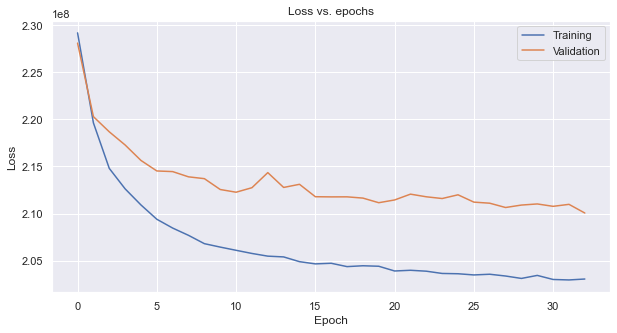

In [139]:
#Run this cell to plot the epoch vs loss graph
plt.figure(figsize=(10, 5))
plt.plot(historydf['loss'])
plt.plot(historydf['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

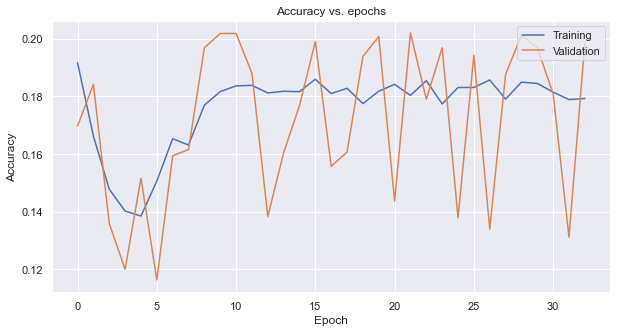

In [140]:
#Run this cell to plot the epoch vs loss graph
plt.figure(figsize=(10, 5))
plt.plot(historydf['accuracy'],label='accuracy')
plt.plot(historydf['val_accuracy'],label='val_accuracy')
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

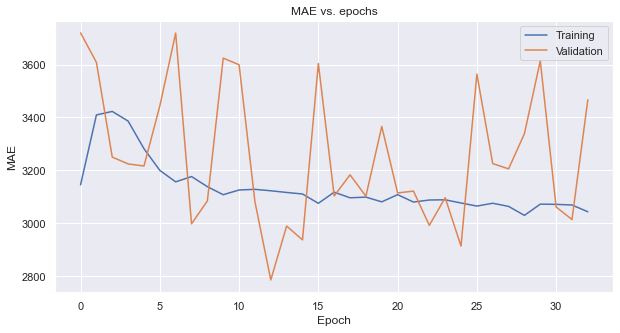

In [141]:
#Run this cell to plot the epoch vs loss graph
plt.figure(figsize=(10, 5))
plt.plot(historydf['mae'],label='mae')
plt.plot(historydf['val_mae'],label='val_mae')
plt.title('MAE vs. epochs')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

## Other

In [ ]:
#XGBModel.get_params().keys()

#search_grid={'n_estimators':[10,50,100,250]}
#searchxgb=GridSearchCV(estimator=XGBModel,param_grid=search_grid,scoring='r2',n_jobs=1,cv=3)
#searchxgb.fit(X_train, y_train)
#print(searchxgb.best_score_)
#print(searchxgb.best_params_)

In [ ]:
#PCA Analysis
X_scaled = StandardScaler().fit_transform(X_train)

pca = PCA(n_components=5)
principalComponents = pca.fit_transform(X_scaled)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2','pc3','pc4','pc5'])

X_pcca = principalDf[['pc1','pc2','pc3','pc4','pc5']]

## Weather data

In [ ]:
# Get weather stations ordered by distance to Vancouver, BC
stations = Stations(lat = 38.843988, lon = -122.759707, daily = datetime(2018, 1, 1))
# Fetch closest station (limit = 1)
station = stations.fetch(1)

data = Daily(station, start = datetime(2018, 1, 1), end = datetime(2018, 1, 1))
# Fetch Pandas DataFrame
data = data.fetch()

data.plot(y=['tavg', 'tmin', 'tmax'])